In [1]:
import torch
from torchvision import transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import cv2
import os
import glob
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import re
import tqdm

%matplotlib inline
plt.style.use('bmh')
torch.manual_seed(18)
torch.set_default_tensor_type('torch.FloatTensor')
g_cuda = torch.Generator(device='cuda')

In [2]:
def load_img_folder(img_dir):
    files = glob.glob(img_dir)
    data = []
    for f1 in files:
        data.append(f1)
    return data

def sort_input(datalist):
    pat=re.compile('\d')
    numlist = [i for i in pat.findall(datalist)][6:]
    num = sum([int(j)*10**int(i) for i,j in enumerate(numlist[:-1][::-1])])*10+int(numlist[-1])
    return num

def sort_test(datalist):
    pat=re.compile('\d')
    numlist = [i for i in pat.findall(datalist)][6:]
    num = sum([int(j)*10**int(i) for i,j in enumerate(numlist[:][::-1])])
    return num

In [3]:
input_data = load_img_folder("/home/f.yang1/CAP5404/Part2/L/*.jpg")
label_data_a = load_img_folder("/home/f.yang1/CAP5404/Part2/a/*.jpg")
label_data_b = load_img_folder("/home/f.yang1/CAP5404/Part2/b/*.jpg")
input_data = sorted(input_data, key = sort_input)
label_data_a = sorted(label_data_a, key = sort_input)
label_data_b = sorted(label_data_b, key = sort_input)

test_data = load_img_folder("/home/f.yang1/CAP5404/Part2/oriimge/*.jpg")
test_data = sorted(test_data, key = sort_test)[-75:]

In [4]:
class Train_Dataset(Dataset):
    def __init__(self):
        self.input_data = input_data[:-750]
        self.label_data_a = label_data_a[:-750]
        self.label_data_b = label_data_b[:-750]
        
    def __getitem__(self, index):
        X = cv2.imread(self.input_data[index],2)
        y1 = cv2.imread(self.label_data_a[index],2)
        y2 = cv2.imread(self.label_data_b[index],2)
        X = transforms.ToTensor()(X).cuda()
        y1 = torch.from_numpy(np.asarray(y1)).cuda()
        y2 = torch.from_numpy(np.asarray(y2)).cuda()
        
        y = torch.stack((y1,y2))
        return X, y

    def __len__(self):
        return len(self.input_data)
    

    
class Test_Dataset(Dataset):
    def __init__(self):
        self.dataset = test_data
        
    def __getitem__(self, index):
        img = cv2.imread(self.dataset[index])
        img = cv2.cvtColor(img,cv2.COLOR_BGR2LAB)
        L,a,b = cv2.split(img)
        X = transforms.ToTensor()(L).cuda()
        y1 = torch.from_numpy(np.asarray(a)).cuda()
        y2 = torch.from_numpy(np.asarray(b)).cuda()
        y = torch.stack((y1,y2))

        return X, y

    def __len__(self):
        return len(self.dataset)

In [5]:
# train input [batch size, 1, 128,128] label [batch size, 2,128,128]
Train_data = Train_Dataset()
Train_Dataloader = DataLoader(Train_data,batch_size=32,shuffle = True,drop_last=True)

# test input [batch size, 1, 128,128] label [batch size, 2,128,128]
Test_data = Test_Dataset()
Test_Dataloader = DataLoader(Test_data,batch_size=75,shuffle = True)

In [6]:
class DownsampleLayer(nn.Module):
    def __init__(self,in_ch,out_ch):
        super(DownsampleLayer, self).__init__()
        self.downsample=nn.Sequential(
            nn.Conv2d(in_channels=in_ch,out_channels=out_ch,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )
    def forward(self,x):
        out=self.downsample(x)
        return out

In [7]:
class UpSampleLayer(nn.Module):
    def __init__(self,in_ch,out_ch,last = False):
        super(UpSampleLayer, self).__init__()
        if last:
            self.upsample=nn.Sequential(
                nn.ConvTranspose2d(in_channels=in_ch,out_channels=out_ch,kernel_size=3,stride=2,padding=1,output_padding=1),
            )
        else:
            self.upsample=nn.Sequential(
                nn.ConvTranspose2d(in_channels=in_ch,out_channels=out_ch,kernel_size=3,stride=2,padding=1,output_padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU()
            )
    def forward(self,x):
        x_out=self.upsample(x)
        return x_out

In [8]:
# [2**(i+3) for i in range(6)]

In [9]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        out_channels=[2**(i+5) for i in range(5)]
        # down
        self.d1=DownsampleLayer(1,out_channels[0])
        self.d2=DownsampleLayer(out_channels[0],out_channels[1])
        self.d3=DownsampleLayer(out_channels[1],out_channels[2])
        self.d4=DownsampleLayer(out_channels[2],out_channels[3])
        self.d5=DownsampleLayer(out_channels[3],out_channels[4])

        # up
        self.u1=UpSampleLayer(out_channels[4],out_channels[3])
        self.u2=UpSampleLayer(out_channels[3],out_channels[2])
        self.u3=UpSampleLayer(out_channels[2],out_channels[1])
        self.u4=UpSampleLayer(out_channels[1],out_channels[0])
        self.u5=UpSampleLayer(out_channels[0], 2, last= True)

    def forward(self, x):
        d1 = self.d1(x)
        d2 = self.d2(d1)
        d3 = self.d3(d2)
        d4 = self.d4(d3)
        d5 = self.d5(d4)
        u1 = self.u1(d5)
        u2 = self.u2(u1)
        u3 = self.u3(u2)
        u4 = self.u4(u3)
        u5 = self.u5(u4)
        
        return u5
        
        
def init_weights(layer):

    if type(layer) == nn.Conv2d:
        nn.init.normal_(layer.weight, mean=0, std=0.5)
        
net = CNN().cuda()
net.apply(init_weights)

CNN(
  (d1): DownsampleLayer(
    (downsample): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (d2): DownsampleLayer(
    (downsample): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (d3): DownsampleLayer(
    (downsample): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (d4): DownsampleLayer(
    (downsample): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU

In [10]:
loss = nn.SmoothL1Loss().cuda()
trainer = torch.optim.Adam(net.parameters(), lr=0.005)
num_epochs = 7
loss_item = []
for epoch in tqdm.tqdm(range(num_epochs)):
    for X,y in Train_Dataloader:
        l = loss(net(X.float()) ,y.float())
        trainer.zero_grad()
        l.backward()
        trainer.step()
        loss_item.append(l.cpu().item())
#     print(l)

100%|██████████| 7/7 [02:04<00:00, 17.83s/it]


Text(0.5, 1.0, 'FCN')

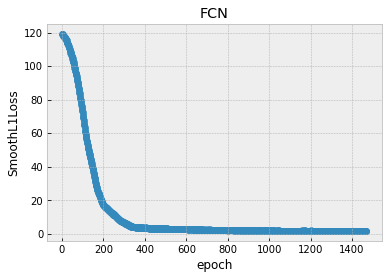

In [11]:
len(loss_item)
x = [i for i in range(1470)]
plt.scatter(x,loss_item)
plt.xlabel("epoch")
plt.ylabel("SmoothL1Loss")

In [12]:
net.eval()
test_loss = nn.MSELoss().cuda()
for X,y in Test_Dataloader:
    with torch.no_grad(): 
        output = net(X.float()) 
    MSE = test_loss(y,output).item()
print("CNN: on the test dataset MSE = {}".format(MSE))

CNN: on the test dataset MSE = 620.1566772460938


In [13]:
def plot(imgs, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    fig.set_figheight(10)
    fig.set_figwidth(30)
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(20)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()   

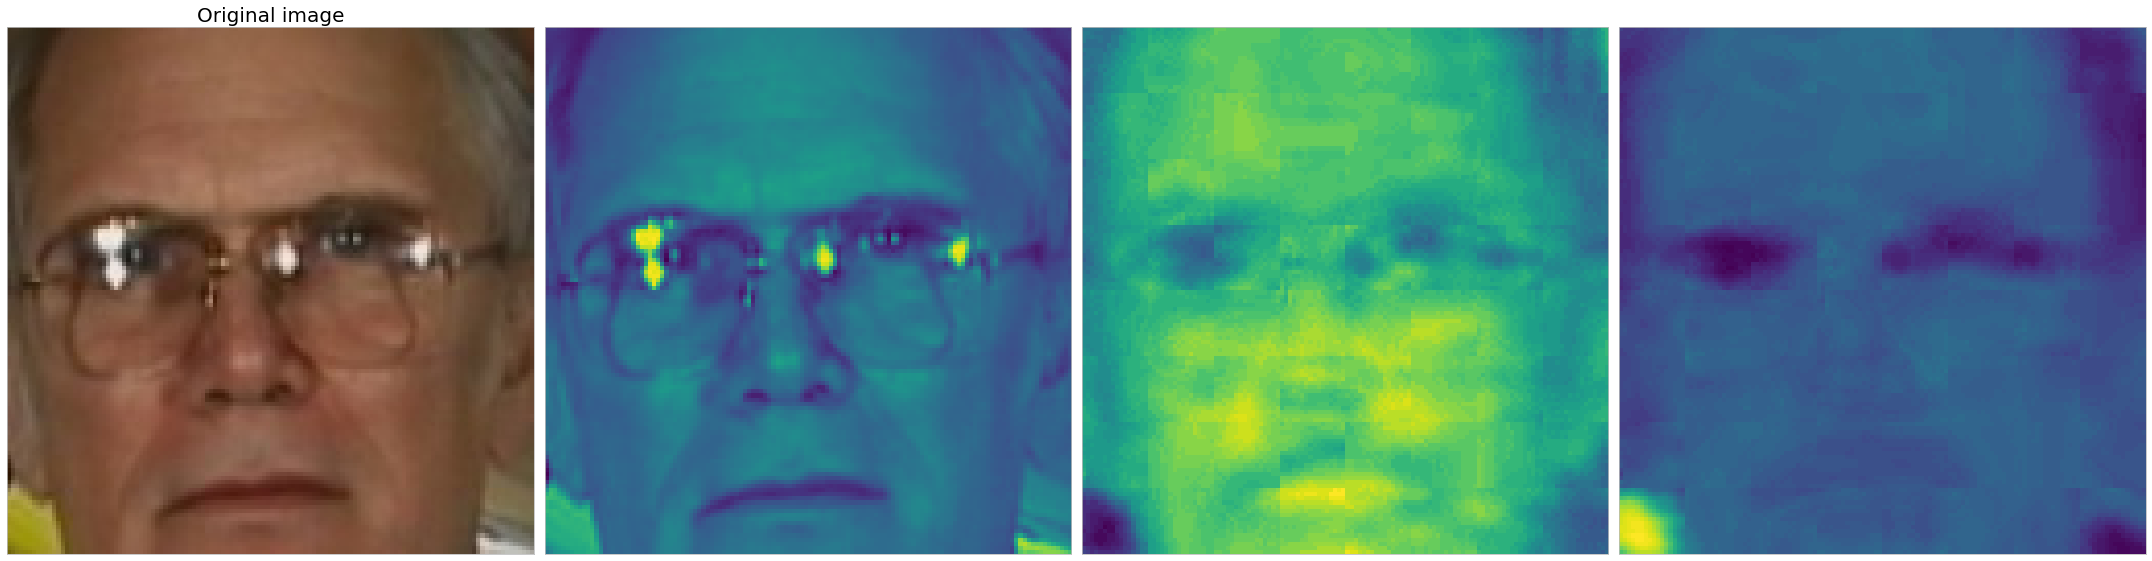

In [14]:
orig_img = Image.open("showimgdir/lab.jpg")
ori = cv2.imread("showimgdir/lab.jpg")
img = cv2.cvtColor(ori, cv2.COLOR_BGR2LAB)
L,a,b = cv2.split(img)
showing = [L,a,b]
plot(showing)

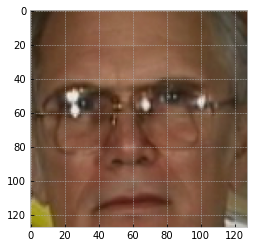

In [15]:
img = cv2.cvtColor(cv2.merge([L,a,b]), cv2.COLOR_LAB2RGB)
plt.imshow(img)

In [16]:
img.shape

(128, 128, 3)

In [33]:
Test_data = Test_Dataset()
Test_Dataloader = DataLoader(Test_data,batch_size=1,shuffle = True)

net.eval()
test_loss = nn.MSELoss().cuda()
for X,y in Test_Dataloader:
    with torch.no_grad(): 
        output = net(X.float()) 
        MSE = test_loss(y,output).item()
        break

print("CNN: on the test dataset MSE = {}".format(MSE))

CNN: on the test dataset MSE = 538.1146240234375


In [34]:
output = output.squeeze().cpu().numpy()
output = output.transpose(1,2,0)
a,b = np.array(cv2.split(output)).astype('uint8')
L = X.reshape(128,128).cpu().numpy()*255
L = L.astype('uint8')
LAB = np.stack([L,a,b])
LAB = LAB.transpose(1,2,0)
RGB_img = cv2.cvtColor(LAB,cv2.COLOR_LAB2BGR)

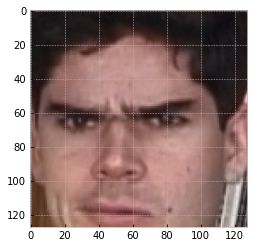

In [35]:
plt.imshow(RGB_img)

In [44]:
np.min(a)

86

In [36]:
# ! mkdir results_img

In [37]:
i = 675
for test_img in test_data:
    save_ori_img = cv2.imread(test_img)
    cv2.imwrite("results_img/ori{}.jpg".format(i),save_ori_img)
    i += 1

In [38]:
Test_data = Test_Dataset()
Test_Dataloader = DataLoader(Test_data,batch_size=1)

net.eval()
test_loss = nn.MSELoss().cuda()
i = 675
for X,y in Test_Dataloader:
    with torch.no_grad(): 
        output = net(X.float()) 
        MSE = test_loss(y,output).item()
        output = output.squeeze().cpu().numpy()
        output = output.transpose(1,2,0)
        a,b = np.array(cv2.split(output)).astype('uint8')
        L = X.reshape(128,128).cpu().numpy()*255
        L = L.astype('uint8')
        LAB = np.stack([L,a,b])
        LAB = LAB.transpose(1,2,0)
        RGB_img = cv2.cvtColor(LAB,cv2.COLOR_LAB2RGB)
        cv2.imwrite("results_img/Colorization{}.jpg".format(i),RGB_img)
        i+=1
# print("CNN: on the test dataset MSE = {}".format(MSE))

In [47]:
b

array([[124, 124, 125, ..., 114, 113, 113],
       [125, 125, 125, ..., 114, 113, 114],
       [125, 125, 125, ..., 114, 114, 113],
       ...,
       [113, 112, 112, ..., 118, 119, 113],
       [112, 112, 112, ..., 118, 126, 109],
       [110, 111, 110, ..., 115, 101,  80]], dtype=uint8)

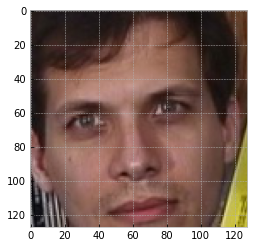

In [39]:
img = cv2.imread("results_img/Colorization675.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
color_img = cv2.imread("results_img/ori675.jpg")
color_img = cv2.cvtColor(color_img,cv2.COLOR_BGR2RGB)
plt.imshow(color_img)
# this one is the network prediction

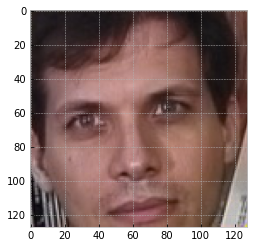

In [40]:
plt.imshow(img)
# this one is the original image

In [25]:
torch.save(net,"colorization.pt")